# Добавление кросс-переменных в модель
## 1. Загрузка библиотек и выборок

In [1]:
import pandas as pd
from scorekit import DataSamples
from scorekit import WOE
from scorekit import LogisticRegressionModel

result_folder = 'titanic_output'
df = pd.read_csv('data/train_titanic.csv')

ds = DataSamples(samples={'train': df}, target='Survived', result_folder='titanic_output', id_column='PassengerId', 
                 samples_split={'test_size': 0.2}, bootstrap_split={'df': df, 'bootstrap_part': 1.5})

Selected features: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
Selected categorical features: ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
Actual parts of samples:
train: 0.7991
Test: 0.2009


## 2. Расчет кросс-переменных на готовой скоркарте и сборка модели


------------------------------------------------------------------------ SFA -------------------------------------------------------------------------

Performing autobinning for cross features with parameters space of size 1...
Finding the best pairs to first-level features...


100%|██████████| 7/7 [00:00<00:00,  7.20it/s]


Creating feature_crosses...


100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.01, 'WOEO_correct_threshold': 0.85, 'WOEO_miss_is_incorrect': True, 'WOEO_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15}
Processing 7 first level features on 1 CPU...


100%|██████████| 7/7 [00:13<00:00,  1.96s/it]


Scorecard saved to the file titanic_output/auto_fit_scorecard.xlsx
All done! Found 21 cross features.
Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)

------------------------------------------------------------------------ MFA -------------------------------------------------------------------------

Transforming features...

---------------------------------------------- Step 1 ----------------------------------------------
Dropped features with gini lower 5: []

---------------------------------------------- Step 2 ----------------------------------------------
Dropped correlated features: []

---------------------------------------------- Step 3 ----------------------------------------------
Stepwise feature selection started...
To add: Sex_WOE, gini: 53.931, p-value: 4.52072881362289e-50
To add: Pclass_WOE, gini: 67.788, p-value: 6.734373110011541e-17
To add: SibSp_WOE, gini: 69.541, p-value: 0.002179486221428463
To add: Age_WOE, gini: 71.027, p-v

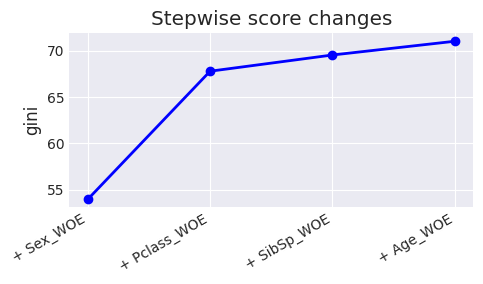


---------------------------------------------- Step 4 ----------------------------------------------
Dropping features with positive coefs and high p-values...
Nothing to drop

------------------------------------------- Final model --------------------------------------------
intercept = -0.834
coefs = {'SibSp_WOE': -0.614, 'Sex_WOE': -0.987, 'Pclass_WOE': -1.049, 'Age_WOE': -0.845}

-------------------------------------------------- MFA for cross features ---------------------------------------------------


---------------------------------------------- Step 1 ----------------------------------------------
Dropped features with gini lower 5: []

---------------------------------------------- Step 2 ----------------------------------------------
Dropped correlated features: ['cross_Embarked&Age_WOE', 'cross_Pclass&Embarked_WOE', 'cross_SibSp&Pclass_WOE', 'cross_Parch&Pclass_WOE', 'cross_Parch&Fare_WOE', 'cross_Age&Pclass_WOE', 'cross_Pclass&Age_WOE', 'cross_Pclass&Fare_WOE', 'cross_

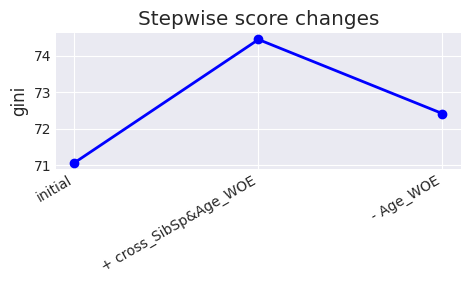


---------------------------------------------- Step 4 ----------------------------------------------
Dropping features with positive coefs and high p-values...
To drop: SibSp_WOE, gini: 19.78, coef: 0.6147183075662026


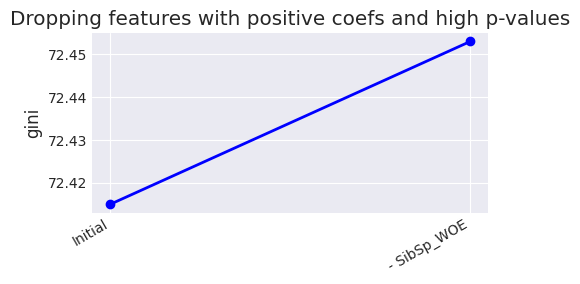


------------------------------------------- Final model --------------------------------------------
intercept = -0.809
coefs = {'Sex_WOE': -1.016, 'Pclass_WOE': -1.081, 'cross_SibSp&Age_WOE': -0.803}
Generating report...


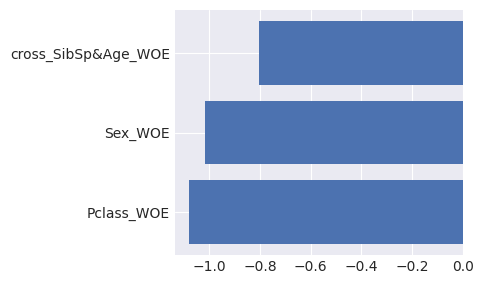

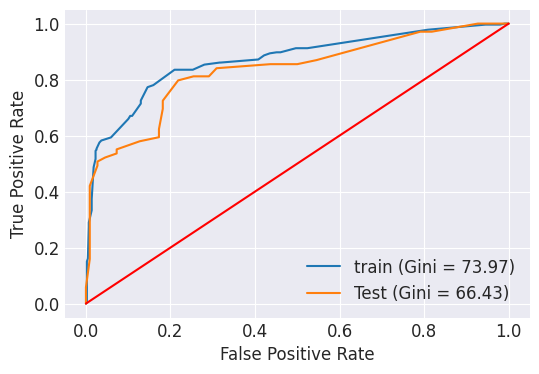

      train   Test  Bootstrap mean  Bootstrap std
Gini  73.97  66.43           72.71           2.13


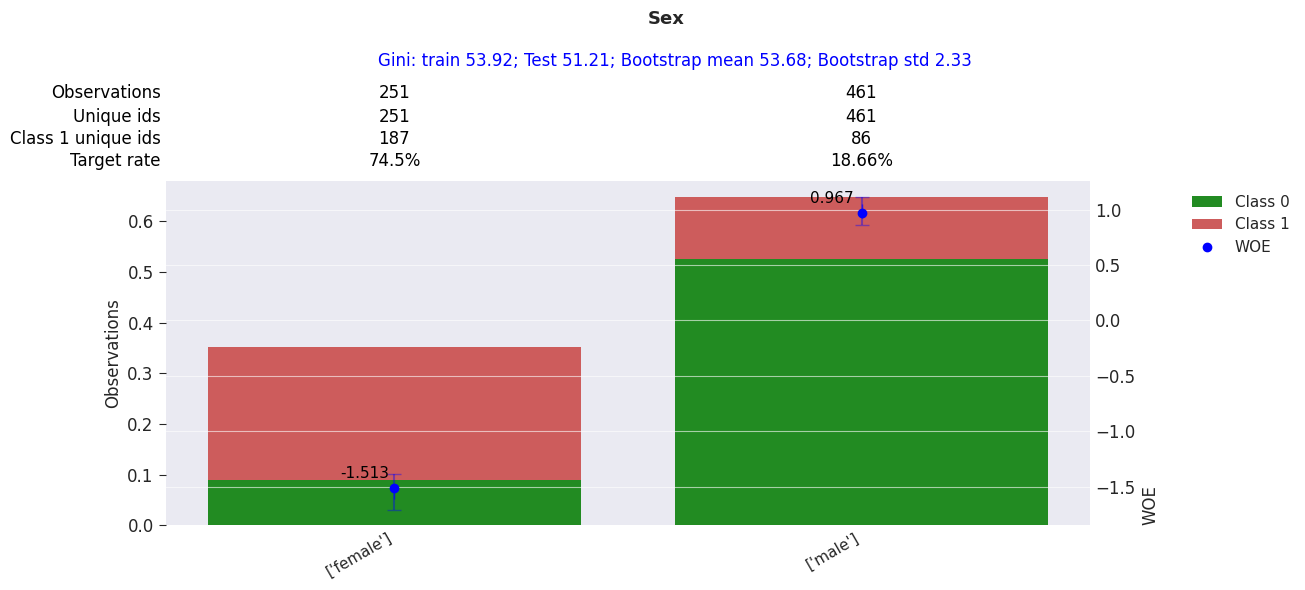

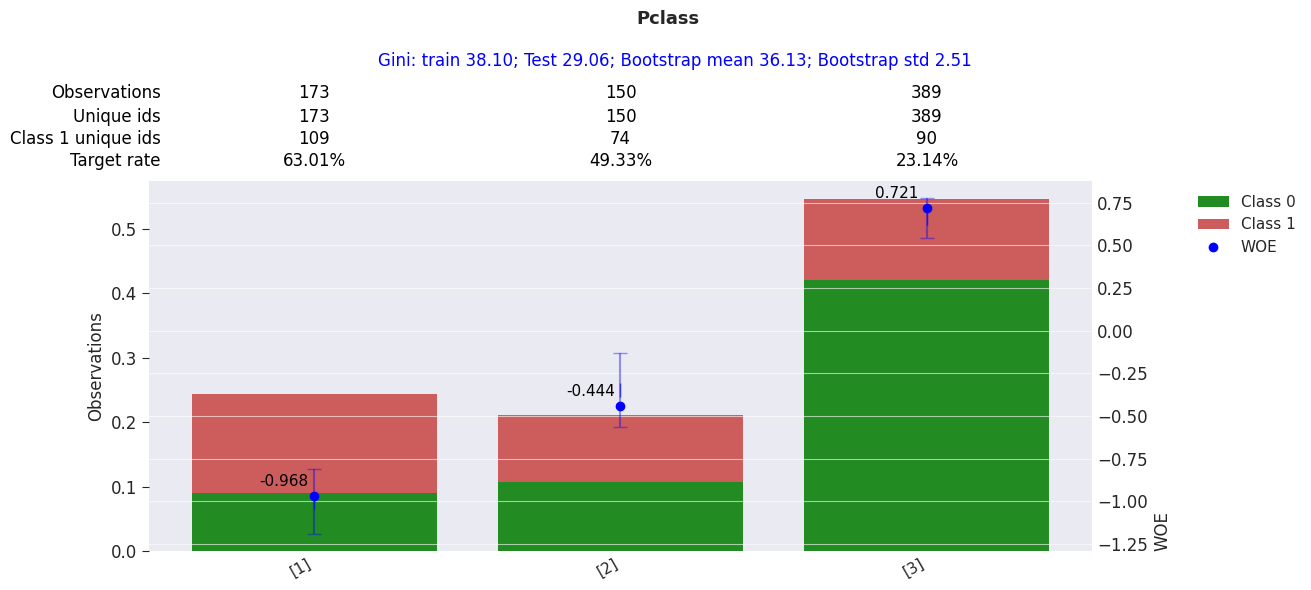

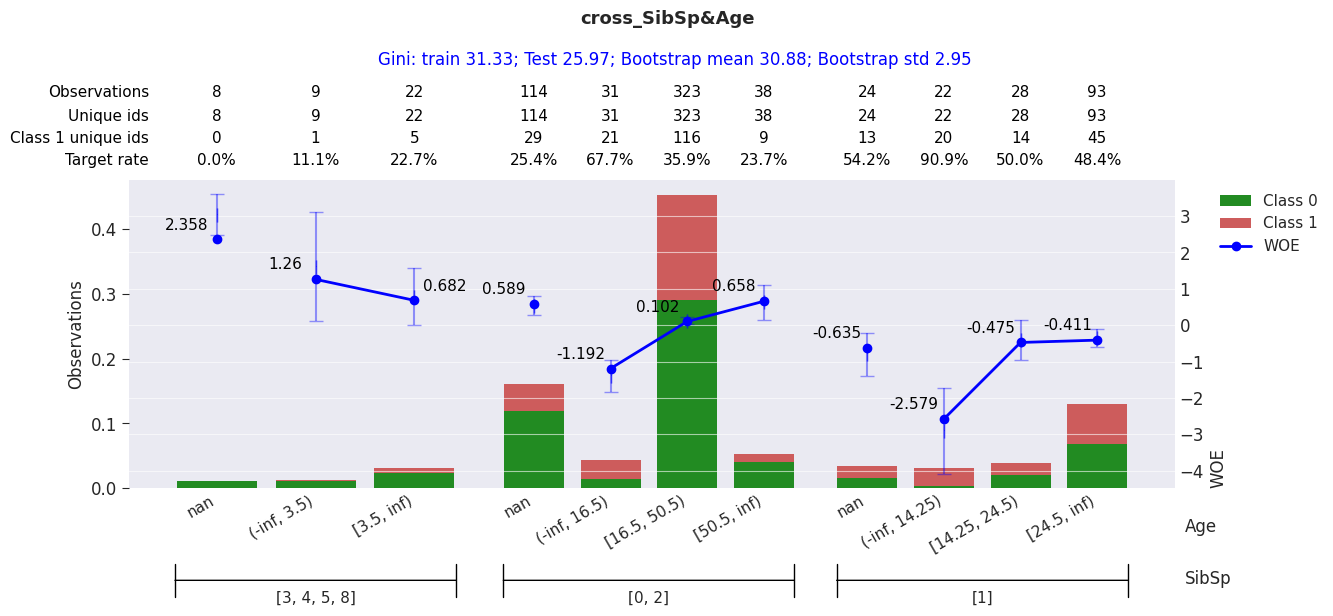

In [2]:
# загрузка биннинга
binning = WOE(ds, scorecard='data/titanic_scorecard.xlsx')

# автобиннинг переменных, отсутвующих в скоркарте модели и последующий поиск кросс-переменных
binning.auto_fit(
                 features=[],                    # при пустом списке автобиннинг обычных переменных не происходит.
                                                 # Для расчета биннинга конркетных кросс-переменных нужно указать их название в списке в явном виде, например   
                                                 # features=['cross_Age&Fare', 'cross_Sex&Parch']
                 #--- Кросс переменные ---
                 cross_features_first_level=None,# список переменных первого уровня для которых будут искаться лучшие кросс пары. При None берется features
                 cross_num_second_level=3        # кол-во кросс пар, рассматриваемых для каждой переменной первого уровня
                                                 #   0 - поиск не производится
                                                 #  -1 - рассматриваются все возможные кросс пары
                                                 #   n - для каждой переменной первого уровня отбираются n лучших переменных с максимальной метрикой criterion
                )
# инициализация модели
logreg = LogisticRegressionModel(ds=ds, transformer=binning)   

# МФА с огранпчением в одну кросс-переменную
logreg.mfa(
           crosses_simple=False,                 # True  - после трансформации кросс-переменные учавствут в отборе наравне со всеми переменными
                                                 # False - сначала выполняется отбор только на основных переменных,
                                                 #     затем в модель добавляются по тем же правилам кросс переменные, но не более, чем crosses_max_num штук
           crosses_max_num=1,                    # максимальное кол-во кросс переменных в модели. учитывается только при crosses_simple=False
          )

## 3. Добавление кросс-переменных в уже готовую модель

Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)
The model was loaded from file data/titanic_model.json
clf = SGDClassifier(alpha=0.001, loss='log', random_state=0)
name = Titanic
coefs = {'SibSp_WOE': -0.624, 'Sex_WOE': -0.826, 'Pclass_WOE': -0.815, 'Fare_WOE': -0.377, 'Age_WOE': -0.852}
intercept = -0.224
calibration = None
scale = None
round_digits = 3

------------------------------------------------------------------------ SFA -------------------------------------------------------------------------

Performing autobinning with parameters space of size 1...
Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2

100%|██████████| 2/2 [00:00<00:00, 12.57it/s]


Performing autobinning for cross features with parameters space of size 1...
Finding the best pairs to first-level features...


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Creating feature_crosses...


100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.2, 'G_gini_increase_restrict': True, 'G_with_test': False, 'WOEO_on': False, 'WOEO_dr_threshold': 0.01, 'WOEO_correct_threshold': 0.85, 'WOEO_miss_is_incorrect': True, 'WOEO_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 15}
Processing 2 first level features on 1 CPU...


100%|██████████| 2/2 [00:03<00:00,  1.77s/it]


Scorecard saved to the file titanic_output/auto_fit_scorecard.xlsx
All done! 2/2 features successfully binned. Found 6 cross features.

------------------------------------------------------------------------ MFA -------------------------------------------------------------------------

Transforming features...

---------------------------------------------- Step 1 ----------------------------------------------
Dropped features with gini lower 5: []

---------------------------------------------- Step 2 ----------------------------------------------
Dropped correlated features: []

---------------------------------------------- Step 3 ----------------------------------------------
Initial features: ['Sex_WOE', 'Fare_WOE', 'SibSp_WOE', 'Age_WOE', 'Pclass_WOE'], gini score 70.349
Stepwise feature selection started...
No significant features to add were found
To drop: Fare_WOE, gini: 71.064, p-value: 0.11148403492469465
No significant features to add were found


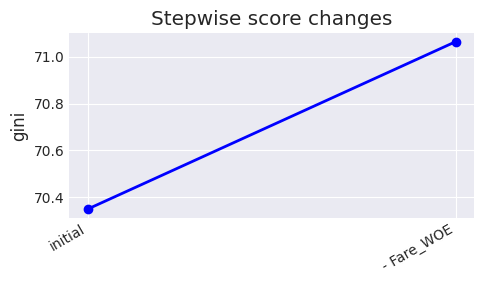


---------------------------------------------- Step 4 ----------------------------------------------
Dropping features with positive coefs and high p-values...
Nothing to drop

------------------------------------------- Final model --------------------------------------------
intercept = -0.834
coefs = {'SibSp_WOE': -0.614, 'Sex_WOE': -0.987, 'Pclass_WOE': -1.049, 'Age_WOE': -0.845}

-------------------------------------------------- MFA for cross features ---------------------------------------------------


---------------------------------------------- Step 1 ----------------------------------------------
Dropped features with gini lower 5: []

---------------------------------------------- Step 2 ----------------------------------------------
Dropped correlated features: ['cross_Parch&Fare_WOE']

---------------------------------------------- Step 3 ----------------------------------------------
Initial features: ['Sex_WOE', 'Pclass_WOE', 'Age_WOE', 'SibSp_WOE'], gini score 71.06

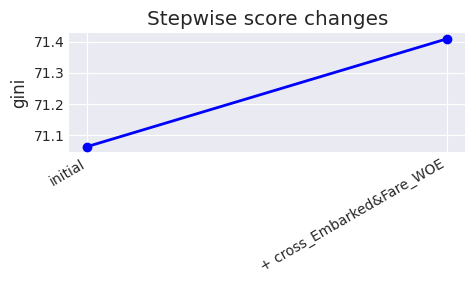


---------------------------------------------- Step 4 ----------------------------------------------
Dropping features with positive coefs and high p-values...
Nothing to drop

------------------------------------------- Final model --------------------------------------------
intercept = -0.614
coefs = {'SibSp_WOE': -0.61, 'Sex_WOE': -1.085, 'Pclass_WOE': -0.684, 'Age_WOE': -0.764, 'cross_Embarked&Fare_WOE': -0.533}
Generating report...


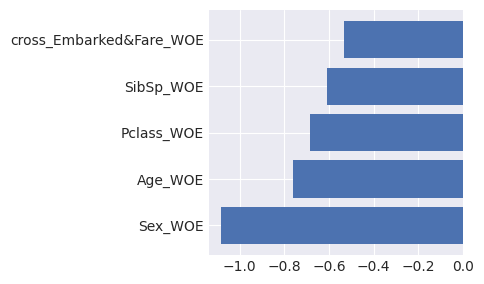

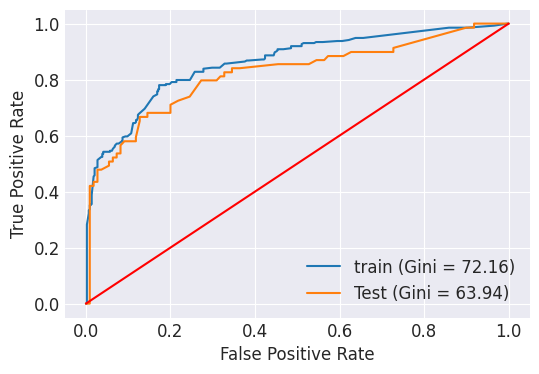

      train   Test  Bootstrap mean  Bootstrap std
Gini  72.16  63.94           70.79            2.3


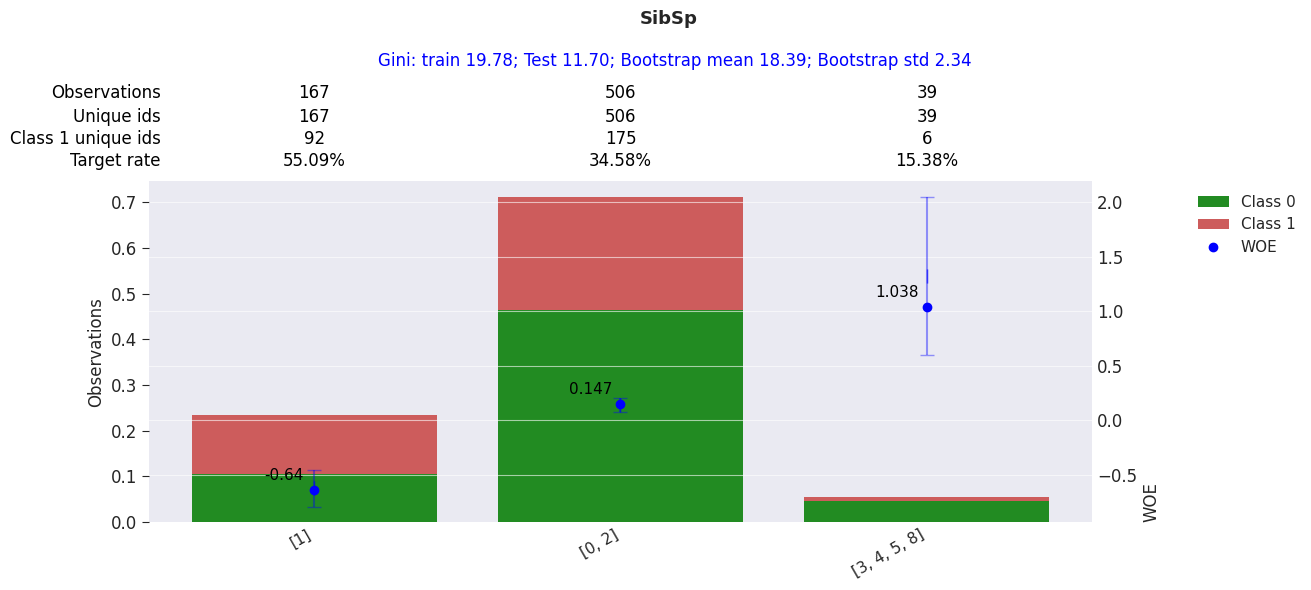

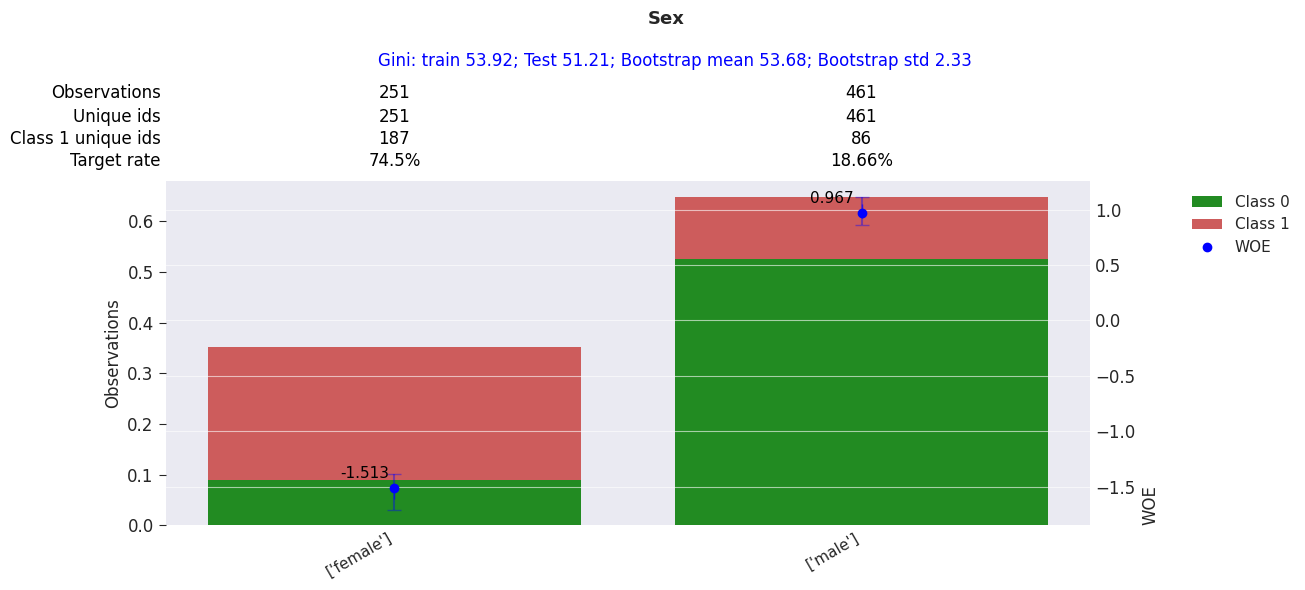

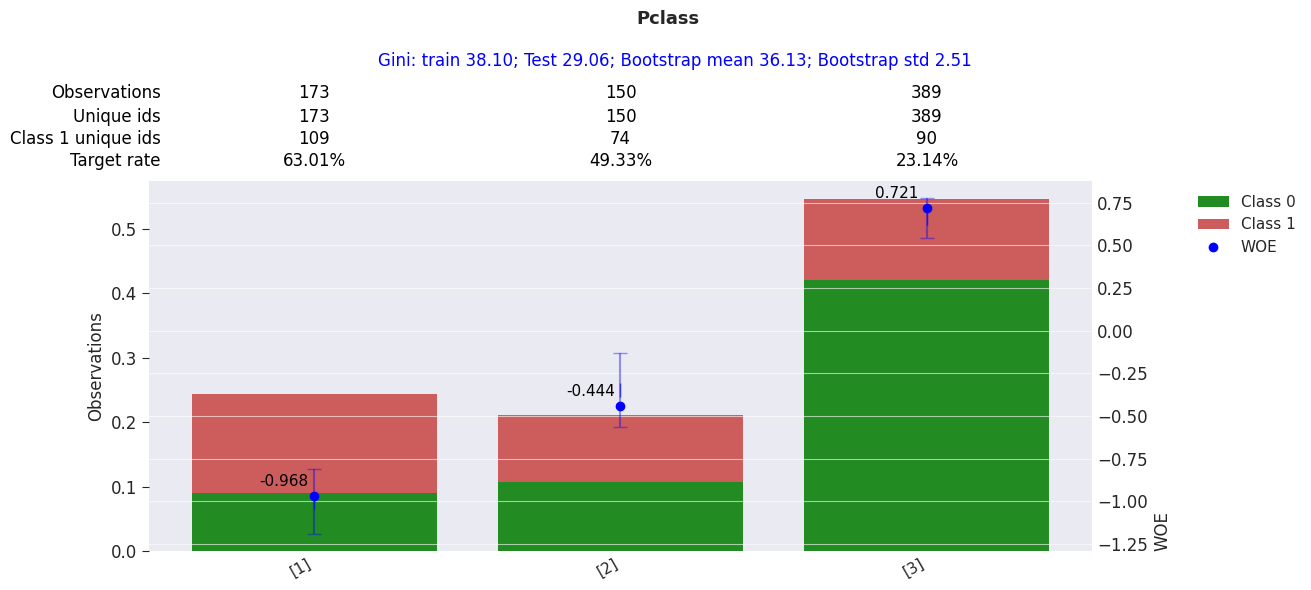

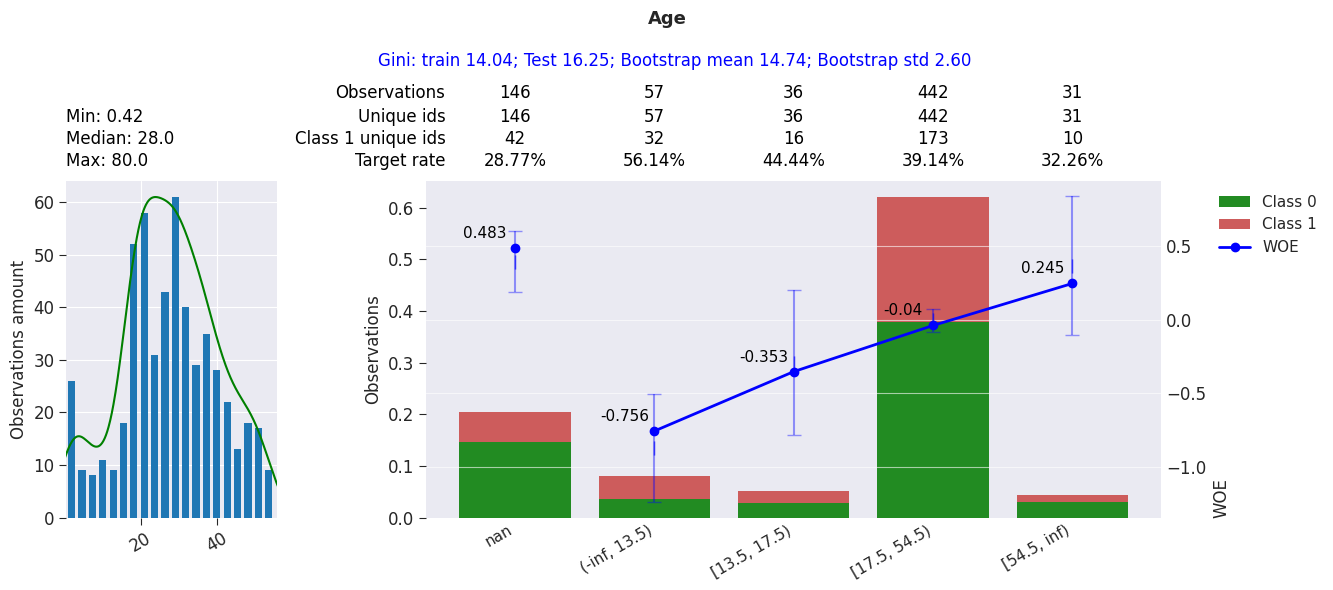

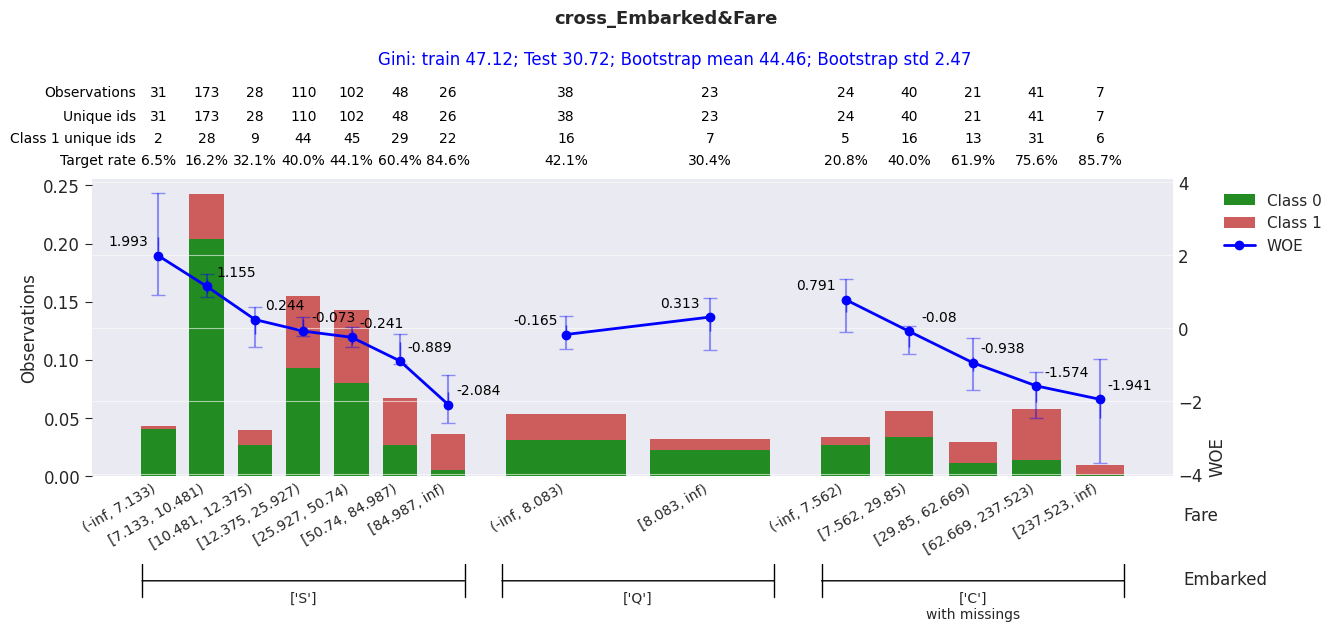

In [3]:
logreg = LogisticRegressionModel(ds=ds)   

# загрузка готовой модели
logreg.load_model(file_name='data/titanic_model.json')

# автобиннинг переменных, отсутвующих в скоркарте модели и последующий поиск кросс-переменных
logreg.transformer.auto_fit(
                             features=list(set(ds.features) - {f[:-4] for f in logreg.features}), # список переменных для обработки. По умолчанию берутся из self.ds.features                 
                             #--- Кросс переменные ---
                             cross_features_first_level=None,# список переменных первого уровня для которых будут искаться лучшие кросс пары. При None берется features
                             cross_num_second_level=3        # кол-во кросс пар, рассматриваемых для каждой переменной первого уровня
                                                             #   0 - поиск не производится
                                                             #  -1 - рассматриваются все возможные кросс пары
                                                             #   n - для каждой переменной первого уровня отбираются n лучших переменных с максимальной метрикой criterion
                            )
# поиск лучше кросс-переменной для добавления в модель
logreg.mfa(
           features_ini=logreg.features,         # список переменных, с которых стартует процедура отбора. Они могут быть исключены в процессе отбора
           crosses_simple=False,                 # True  - после трансформации кросс-переменные учавствут в отборе наравне со всеми переменными
                                                 # False - сначала выполняется отбор только на основных переменных,
                                                 #     затем в модель добавляются по тем же правилам кросс переменные, но не более, чем crosses_max_num штук
           crosses_max_num=1,                    # максимальное кол-во кросс переменных в модели. учитывается только при crosses_simple=False
          )

### 4. Генерация хардкода для использования модели без сторонних библиотек

In [4]:
logreg.to_py(file_name=f'{result_folder}/titanic_model.py', # название питоновского файла, куда должен быть сохранен код
             score_field='score',                           # поле, в которое должен быть записан посчитанный скор
             pd_field='prob',                               # поле, в которое должен быть записан посчитанный PD
             scale_field=None                               # поле, в которое должен быть записан посчитанный грейд
            )

The model code for implementation saved to file titanic_output/titanic_model.py
import pandas as pd
import numpy as np


def scoring(df, score_field='score', pd_field='pd', scale_field=None):
    """
    Функция скоринга выборки
    Arguments:
        df: [pd.DataFrame] входной ДатаФрейм, должен содержать все нетрансформированные переменные модели
        score_field: [str] поле, в которое должен быть записан посчитанный скор
        pd_field: [str] поле, в которое должен быть записан посчитанный PD
        scale_field: [str] поле, в которое должен быть записан посчитанный грейд
    Returns:
        df: [pd.DataFrame] выходной ДатаФрейм с добавленными полями трансформированных переменных, скоров, PD и грейда
    """

    df['SibSp_WOE'] = np.where(df['SibSp'].isin([3, 4, 5, 8]), 1.038, 
                               np.where(df['SibSp'].isin([0, 2]), 0.147, 
                                        np.where(df['SibSp'].isin([1]), -0.64, 
                                                